In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import randint
from rouge import Rouge

from main.common.common import *
from main.common.vocab import *
from main.common.simple_vocab import SimpleVocab
from main.common.util.file_util import FileUtil
from main.data.cnn_dataloader import *
from main.seq2seq import Seq2Seq

In [3]:
def show_attention_graph(article, summary, attention):
    article = article.split()
    summary = summary.split()
  
    attention = (attention[:, :-1])
    
    # figure
    figure = plt.figure(figsize=(20, 5))
    ax = figure.add_subplot(111)
    
    cax = ax.matshow(attention.numpy(), cmap='bone')
    figure.colorbar(cax)
    
    # set up axes
    ax.set_xticklabels([''] + article + ['[STOP]'], rotation=90)
    ax.set_yticklabels([''] + summary)

    # show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()
    
def get_score(summary, reference):
    rouge = Rouge()
    
    summary = summary.split()        
    summary = [w for w in summary if w != TK_STOP['word']]
    
    score = rouge.get_scores(' '.join(summary), reference)[0]["rouge-l"]["f"]

    return score

In [4]:
AppContext()

vocab = SimpleVocab(FileUtil.get_file_path(conf('vocab-file')), conf('vocab-size'))

seq2seq = cuda(Seq2Seq(vocab))

checkpoint = t.load(FileUtil.get_file_path(conf('model-file')))

seq2seq.load_state_dict(checkpoint['model_state_dict'])

seq2seq.eval()

data_loader =  CNNDataLoader(FileUtil.get_file_path(conf('train:article-file')),
                                         FileUtil.get_file_path(conf('train:summary-file')),
                                         FileUtil.get_file_path(conf('train:keyword-file')),
                                         conf('train:batch-size'))

2019-05-25 21:08:58 MainThread   DEBUG SimpleVocab:22 - initialize vocabulary from: /Users/Sotheara/PycharmProjects/kw-txt-summarization/data/extract/vocab.txt


>>> article:  dafniya , libya ( cnn ) -- libyan leader moammar gadhafi 's forces fired mortars and guns at rebel forces in an apparent effort to break through a stalemated line west of the rebel - held city of misrata on sunday , cnn 's ben wedeman reported from the scene . rebels returned fire , and while some pulled back to seek cover from the incoming artillery shells , others moved forward toward the front line near the town of dafniya , about 35 kilometers west of misrata . libya has been in the throes of a civil war for months , since gadhafi dug in his heels against popular efforts to force him out of power as anti - government protests sweep the arab world this year .
>>> keyword:  
>>> reference:  rebels in libya come under attack at a stalemated front line near a rebel - held city . moammar gadhafi has been fighting efforts to topple him as protests sweep the arab world .
>>> prediction:  rebels in libya come under attack on a stalemated front line near a rebel - held city . 

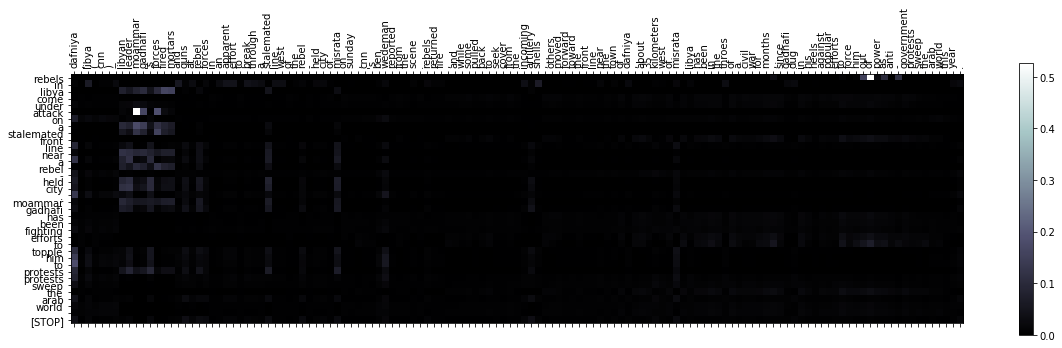

In [6]:
samples = data_loader.read_all()

article, keyword, reference = samples[randint(0, len(samples) - 1)]

keyword = keyword[0]
reference = reference[0]
    
summary, attention = seq2seq.evaluate(article, keyword)

score = get_score(summary, reference)

print('>>> article: ', article)
print('>>> keyword: ', keyword)
print('========================')
print('>>> reference: ', reference)
print('>>> prediction: ', summary)
print('>>> score: ', score)

show_attention_graph(article, summary, attention)